# Packet timing analysis

We start by loading some required packages and telling matplotlib to plot with **big** fonts.

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

font = {'family' : 'helvetica',
        'size'   : 20}

matplotlib.rc('font', **font)

Read the `statistics.csv` file (as generated by the `sppextract-samplecount.c`) and name each column.

In [19]:
df = pd.read_csv('statistics.csv', names = ['offset', 'seq_hex', 'apid_hex', 'seq', 'size', 'data'])

Extract the APIDs and offsets of each individual packet

In [20]:
apids   = df['apid_hex']
offsets = df['offset']

Now, we are going to compose a dictionary named `apid_occurrences` which, for each APID, will hold the packet number and offset inside the `frames.bin` at which it shows up.

In [21]:
n = 0
apid_occurrences = {}
max_offset = 0

for apid, offset in zip(apids, offsets):
    if apid not in apid_occurrences:
        apid_occurrences[apid] = []
        
    apid_occurrences[apid].append((n, offset))
    if offset > max_offset:
        max_offset = offset
    n += 1

print('Max offset:',max_offset)

Max offset: 7343397


We now build an offset axis (`x_axis`) with certain resolution (10000 offsets between minimum and maximum is more than enough). On top of this axis, we define a series of step functions centered around the first occurrence of each APID. By adding them by APID in the `apid_counts` dictionary, we will construct a monotonically increasing occurrence plot per APID, from which we can extract information like the time of first occurrence or packet rate.

In [22]:
apid_counts  = {}
apid_offsets = {}
apid_locs    = {}
length       = len(apids)
RESOLUTION   = 10000
p_axis       = np.linspace(0, length - 1, length)
x_axis       = np.linspace(0, max_offset, RESOLUTION)

for apid in apid_occurrences:
    apid_counts[apid] = np.zeros(RESOLUTION)
    apid_offsets[apid] = []
    
    for loc, offset in apid_occurrences[apid]:
        step = (x_axis >= offset).astype(float)
        apid_counts[apid] += step


However, the offset axis is difficult to visualize. We are interested in how offsets relate to time with respect to the start of the capture.

According to our previous analyses, the symbol rate of the BPSK subcarrier was 52639 baud. Since the turbocode rate was 1/2, we were actually deliverying symbols at a slower pace (in particular, one half of the symbol rate). Additionally, offsets are specified in bytes not in bits, so we have to divide the bit rate by 8 to obtain a byte rate.

Finally, we started the demodulation at roughly the start of the capture file (which in turn started at 19:11 UTC). We simply perform a change of units from bytes to minutes from the beginning of the file, and add 11 minutes to calculate the time elapsed after 19:00.

In [23]:
SYMBOL_RATE=52639.0
BIT_RATE=SYMBOL_RATE/2
BYTE_RATE=BIT_RATE/8

t_axis = x_axis / (BYTE_RATE * 60) + 11

We now plot all the occurrences per APID and draw a vertical line on 19:16, indicating when the message was expected to be received. This would let us analyze changes in the behavior of the telemetry downlink right after the expected arrival time.

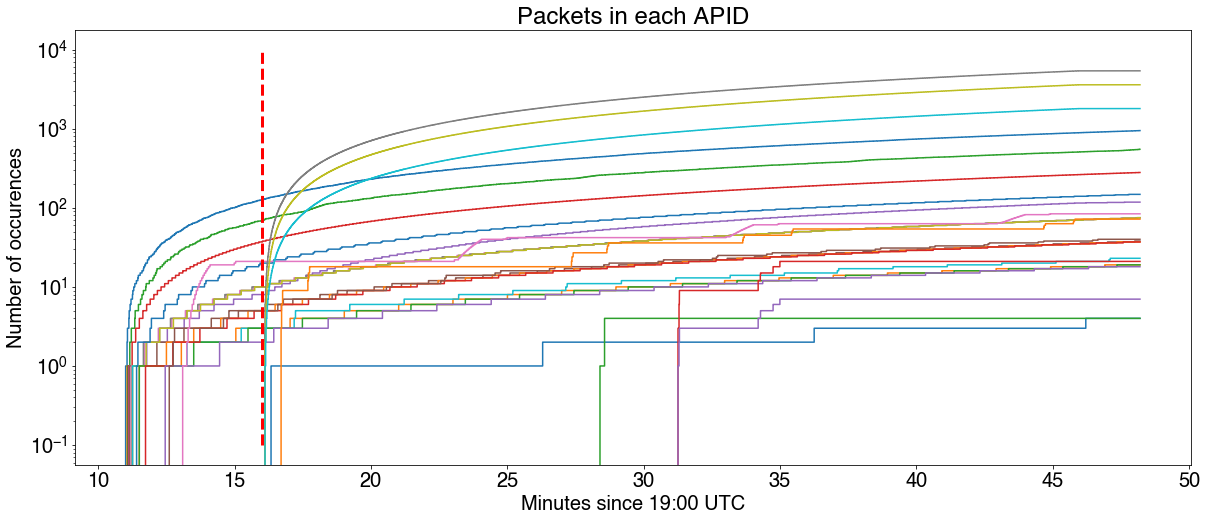

In [27]:
plt.figure(figsize=(20, 8))
for apid in apid_occurrences:
    plt.step(t_axis, apid_counts[apid], where = 'post', label = apid)
plt.xlabel('Minutes since 19:00 UTC')
plt.ylabel('Number of occurences')
plt.gca().set_yscale('log')
plt.title('Packets in each APID')
plt.plot([16, 16], [1e-1, 1e4], color = 'red', linewidth = 3, linestyle='dashed', label='Expected transmission arrival')

[We have a bogey](https://youtu.be/NCkbekhUdw4?t=83)! We definitely found 3 strong candidate APIDs for the signal. If we filter out all APIDs that were already active before 19:16, we obtain their exact numbers.

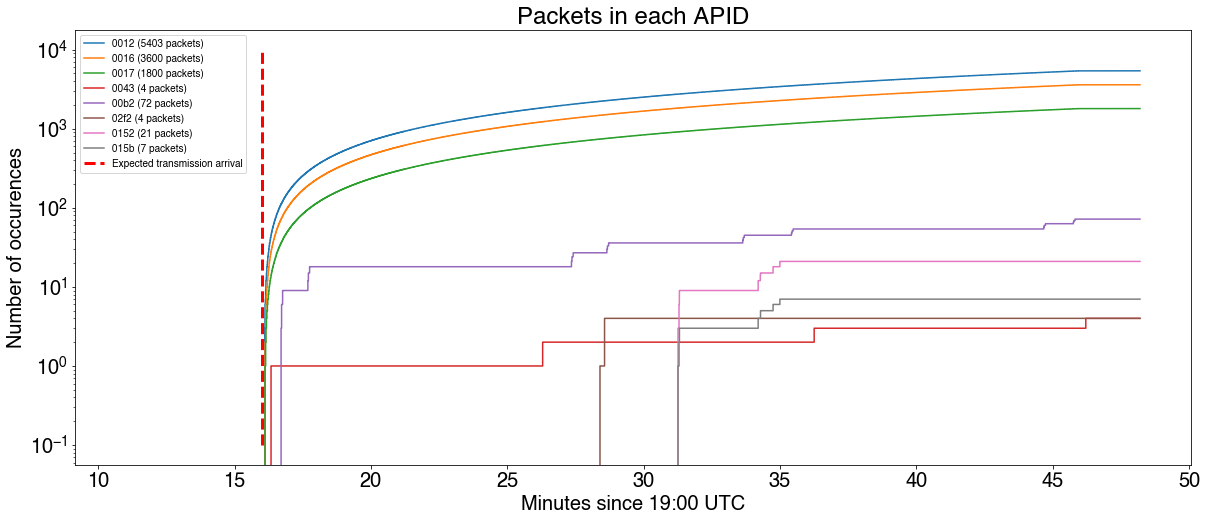

In [31]:
plt.figure(figsize=(20, 8))
for apid in apid_occurrences:
    occurrence = apid_occurrences[apid][0][1] / (BYTE_RATE * 60) + 11
    if occurrence > 16:
        num = len(apid_occurrences[apid])
        plt.step(t_axis, apid_counts[apid], where = 'post', label = fr'{apid} ({num} packets)')
plt.xlabel('Minutes since 19:00 UTC')
plt.ylabel('Number of occurences')
plt.gca().set_yscale('log')
plt.title('Packets in each APID')
plt.plot([16, 16], [1e-1, 1e4], color = 'red', linewidth = 3, linestyle='dashed', label='Expected transmission arrival')
plt.legend(fontsize=10)

So we conclude that the ones we are more interested in are **0012** (5403 packets), **0016** (3600 packets) and **0017**. The stream of all

In [26]:
print('Capture length:', max_offset / (BYTE_RATE * 60))

Capture length: 37.201299416782234
